In [5]:
import tensorflow as tf
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import dataset

In [6]:
def visualize(anchor, positive, negative):
    # visualize a triplet

    def show(ax, image, title):
        ax.imshow(image)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    axs = fig.subplots(1, 3)

    show(axs[0], anchor, "Anchor")
    show(axs[1], positive, "Positive")
    show(axs[2], negative, "Negative")

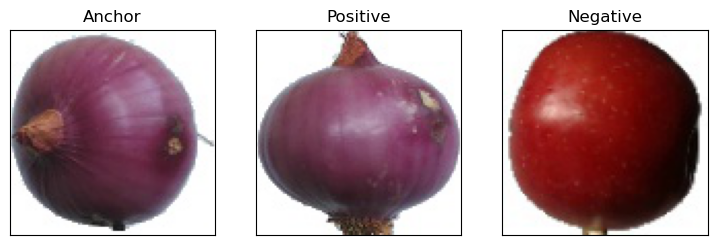

In [11]:
tp = dataset.TripletGenerator("fruits-360/Training")
tp.generate_all_fruits_dict()
photos_generator = tp.get_next_element()
photos = next(photos_generator)
# print(next(photos)[0])
a = mpimg.imread(photos[0])
p = mpimg.imread(photos[1])
n = mpimg.imread(photos[2])

visualize(a, p, n)